In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from Video import Video
from parameters import * 
import pickle
import numpy as np
from windows import slide_window, search_windows
from heat import add_heat, apply_threshold
from scipy.ndimage.measurements import label

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from annotate import draw_boxes, draw_labeled_bboxes

In [2]:
video = Video(30)
clip = VideoFileClip("project_video.mp4")
images = [clip.get_frame(8), clip.get_frame(9), clip.get_frame(10), clip.get_frame(11), clip.get_frame(12), clip.get_frame(13)]

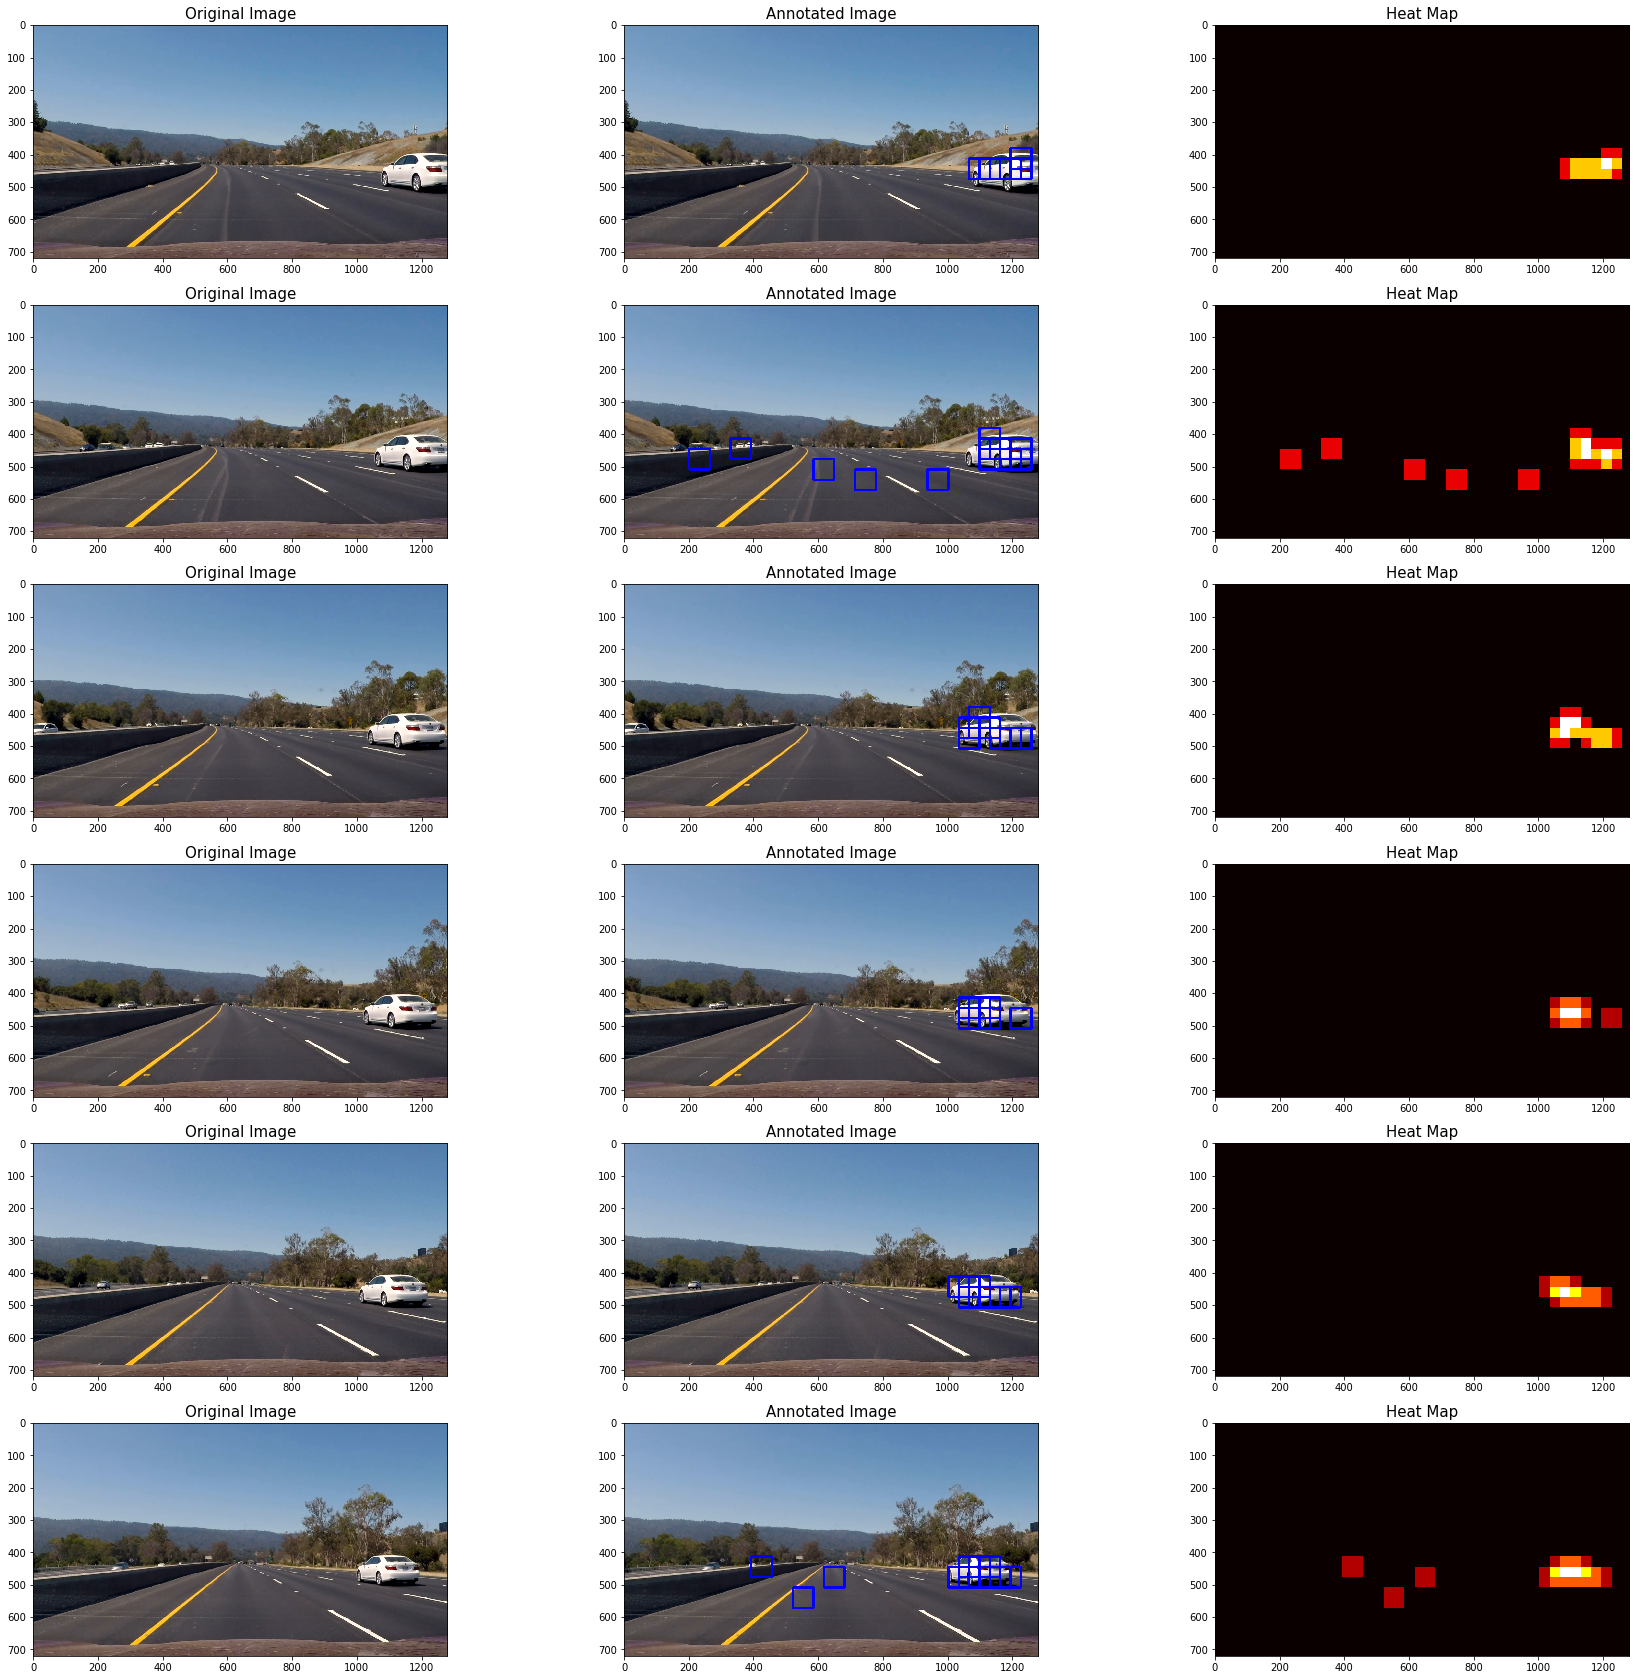

In [3]:
%matplotlib inline

with open(MODEL_FILE, mode='rb') as f:
    model_data = pickle.load(f)
model = model_data['svc']
X_scaler = model_data['X_scaler']
    
types = 3
f, axes = plt.subplots(len(images), types, figsize=(30,30))
axes = axes.ravel()

for i, image in enumerate(images):
    axes[types*i].imshow(image)
    axes[types*i].set_title('Original Image', fontsize=15)
    
    draw_image = np.copy(image)
    windows = slide_window(draw_image, x_start_stop=X_START_STOP, y_start_stop=Y_START_STOP, 
                           xy_window=XY_WINDOW, xy_overlap=XY_OVERLAP)
    hot_windows = search_windows(draw_image, windows, model, X_scaler, 
                                 color_space=COLOR_SPACE, 
                                 spatial_size=SPATIAL_SIZE, 
                                 hist_bins=HIST_BINS, 
                                 orient=ORIENT, 
                                 pix_per_cell=PIX_PER_CELL, 
                                 cell_per_block=CELL_PER_BLOCK, 
                                 hog_channel=HOG_CHANNEL, 
                                 spatial_feat=SPATIAL_FEAT, 
                                 hist_feat=HIST_FEAT, 
                                 hog_feat=HOG_FEAT)
    video.add_to_windows(hot_windows)
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    axes[types*i+1].imshow(window_img)
    axes[types*i+1].set_title('Annotated Image', fontsize=15)
        
    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    axes[types*i+2].imshow(heat, cmap='hot')
    axes[types*i+2].set_title('Heat Map', fontsize=15)
    
plt.savefig('./output_images/heat_map_vis.png')

1 cars found


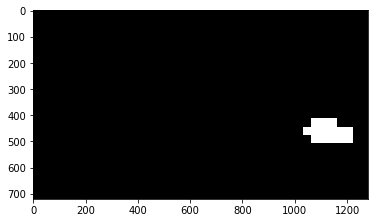

In [4]:
heat_all = np.zeros_like(images[0][:,:,0]).astype(np.float)
heat_all = add_heat(heat_all, video.get_windows())
heat_all = apply_threshold(heat_all, 6)
# Visualize the heatmap when displaying    
heatmap_all = np.clip(heat_all, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap_all)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.savefig('./output_images/label_vis.png')

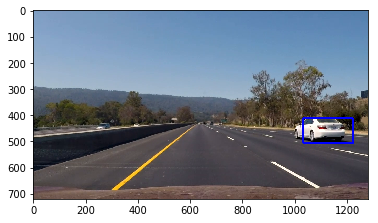

In [5]:
# Read in the last image above
image = images[5]
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)
plt.savefig('./output_images/labeled_boxes_vis.png')